<a href="https://colab.research.google.com/github/lhuang-pvamu/Parallel-Computing-Code/blob/master/Numba_cuda_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numba Cuda Kernel Tutorial

Ufuncs are the easiest way to write a Numba program on GPU and multicores. However, some functions are complex or need more flexibility to use Ufuncs, in which case you may define a CUDA Kernel. 

To write a CUDA kernal, it is essential to understand the diagram below, which shows the a thread grid divided into blocks of threads in a GPU. A kernel is to define the execution of ***a single thread*** in the thread grid. 

To decide the best size for the CUDA thread grid is not easy depending on the algorithm and GPU architectures, some rules of thumb:



1.   The size of a block should be a multiple of 32 threads, such as 128 or 512 threads per block.
2.   The size of the grid should ensure the  GPU is fully utilized. The number blocks is 2x-4x the number of "multiprocessors" on the GPU is a good starting place. The number of blocks are in the range of 20-100.
3. The CUDA kernel launch overhead depends on the number blocks. 



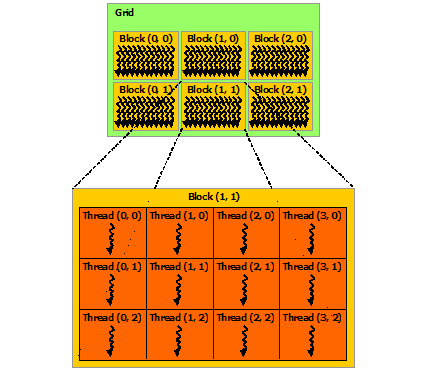

In [ ]:
def add(x,y,out):
  out = x + y

In [ ]:
from numba import cuda,jit,vectorize

@cuda.jit
def add_kernel(x,y,out):
  tx = cuda.threadIdx.x  # the thread ID in a 1D block
  ty = cuda.blockIdx.x  # the block ID in a 1D grid

  block_size = cuda.blockDim.x # number of threads per block
  grid_size = cuda.gridDim.x # number of blocks in the grid

  start = tx + ty*block_size
  stride = block_size * grid_size

  for i in range(start, x.shape[0], stride):
    out[i] = x[i]+y[i]


In [ ]:
import numpy as np

n = 1000000
x = np.arange(n).astype(np.float32)
y = 2.0 * x
out = np.empty_like(x)

threads_per_block = 512
blocks_per_grid = 30



In [ ]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)
print(out[:10])

100 loops, best of 5: 7.75 ms per loop
[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]


In [ ]:
%timeit np.add(x,y)

1000 loops, best of 5: 665 µs per loop


In [ ]:
@vectorize(['int64(int64, int64)','float32(float32, float32)'], target='cuda')
def add_ufunc(x,y):
  return x+y

In [ ]:
%timeit add_ufunc(x,y)

100 loops, best of 5: 5.74 ms per loop


In [ ]:
@cuda.jit
def add_kernel(x, y, out):
    start = cuda.grid(1)      # 1 = one dimensional thread grid, returns a single value
    stride = cuda.gridsize(1) # ditto

    # assuming x and y inputs are same length
    for i in range(start, x.shape[0], stride):
        out[i] = x[i] + y[i]

In [ ]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)
out_device = cuda.device_array_like(x)

In [ ]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x, y, out)

100 loops, best of 5: 7.81 ms per loop


In [ ]:
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); out_device.copy_to_host()


1000 loops, best of 5: 1.33 ms per loop


##Kernel Synchronization

In [ ]:
# GPU input/output arrays, no synchronization (but force sync before and after)
cuda.synchronize()
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device)
cuda.synchronize()

1000 loops, best of 5: 277 µs per loop


In [ ]:
# GPU input/output arrays, include explicit synchronization in timing
cuda.synchronize()
%timeit add_kernel[blocks_per_grid, threads_per_block](x_device, y_device, out_device); cuda.synchronize()

1000 loops, best of 5: 402 µs per loop


## Atomic Operations

In [ ]:
@cuda.jit
def race_condition_increment(global_counter):  # wrong
  global_counter[0] += 1

In [ ]:
@cuda.jit
def thread_safe_increment(global_counter): #
  cuda.atomic.add(global_counter, 0, 1)

In [ ]:
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
race_condition_increment[64, 64](global_counter)
print(64*64, global_counter.copy_to_host())

In [ ]:
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_safe_increment[64, 64](global_counter)
print(64*64, global_counter.copy_to_host())